#### In this tutorial we will be characterising the frequency response of your TCLab unit. 

- Plot a Bode diagram of the FOPDT model you fit to your TCLab for the project
- Subject your TCLab sinusoidal variation of Q1 (Q₁ = Q̅ + Asin(ωt)) for at least 5 different values of ω chosen to be on both sides of the corner frequency of your FOPDT model.
- Find the amplitude ratio and phase angle for the responses to sinusoidal forcing and plot them as dots on your Bode diagram.
- Now subject your TCLab to a random set of pulses with long enough constant parts that the temperature has time to respond.
- Use the input Q1 and the output T1 together with numpy.fft.rfft to determine a numeric estimate of the frequency response. Plot this on the same graph as before.

Once you have characterised the open loop response of your unit, use the frequency response to find the largest gain that can be used for a PI controller with a time constant of 100 seconds (use the Bode stability criterion). Compare this to the answer you obtained in Tut 2. Was this process easier or harder than Tut 2? Which was more accurate?

#### Submit

- code in a notebook which you used to produce the response data
- code in a notebook which can be run to produce your resulting bode diagrams (note this should be separate).
- the data required to run the notebook above (your notebook should not require the TCLab to be connected).
- A two page report with graphs showing the results of your bode diagrams (system and system with controller) and including a brief discussion.

In [1]:
import tclab
from tclab import Plotter, clock, Historian
import datetime

import numpy as np
import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ω = np.logspace(-4, 1, 1000)
s = 1j*ω

Kp, τp, θp, To_p = (0.6423177737615754, 150.3121523254063, 17.396993066317368, 57.79957014481422)

G = Kp/(τp*s + 1)*np.exp(-θp*s)

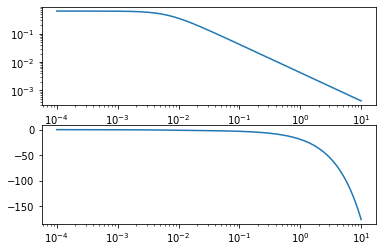

In [4]:
fig, [ax_mag, ax_phase] = plt.subplots(2, 1)
ax_mag.loglog(ω, np.abs(G))
ax_phase.semilogx(ω, np.unwrap(np.angle(G)))
plt.show()

- From the above graph, the corner frequency is around 10^-2
- Choose Omega's in the range 10^-3 to 10^-1 and run the sinusoidal plots

In [5]:
ωs = np.logspace(-2.4, -2, 5)
ωs

array([0.00398107, 0.00501187, 0.00630957, 0.00794328, 0.01      ])

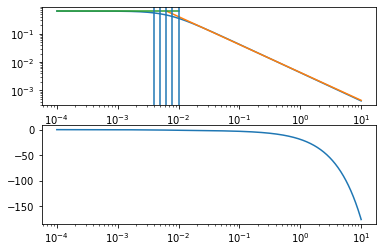

In [6]:
fig, [ax_mag, ax_phase] = plt.subplots(2, 1)
ax_mag.loglog(ω, np.abs(G))
ax_phase.semilogx(ω, np.unwrap(np.angle(G)))
ax_mag.loglog([10**-2.2, 10**1], [Kp, 10**-3.35]) # Green line from (10**-2.2, Kp) to (10**1, 10**-3.35)
ax_mag.loglog([10**-4, 10**-2], [Kp, Kp]) # Green line from (10**-4, Kp) to (10**-2, Kp)

for i in ωs: # These 5 are the chosen omegas
    ax_mag.axvline(i) # Plot a vertical line at the chosen ω to see where it falls around the corner frequency
    
plt.show()

- To find the runtime for the TCLab to get good results, we want at least 3 full sinusoidal periods. 
-  $P = \frac{2\pi}{\omega}$
- Calculate the period for each $\omega$ and multiply it by 3 to get 3 full sinusoids.
- Add 1000s for the TCLab to reach steady state

In [7]:
P_list = [] # List of period values
for ω_l in ωs: # These 5 are the chosen omegas
    P_list.append(2*np.pi/ω_l)

In [8]:
delay = 1

In [9]:
time_span = np.array(P_list)*0.3 + delay
time_span

array([474.47943759, 377.09808584, 299.74532861, 238.30184951,
       189.49555922])

In [10]:
total_time_min = sum(time_span)
str(datetime.timedelta(seconds=total_time_min)), total_time_min

('0:26:19.120261', 1579.1202607660002)

The highest value in this list is 5735s, therefore run all the of them for this time to avoid complication

In [11]:
run_length = max(time_span)
total_time = run_length*len(ωs)
str(datetime.timedelta(seconds=total_time)), total_time

('0:39:32.397188', 2372.3971879647124)

In [ ]:
#time_span = array of run lengths in seconds

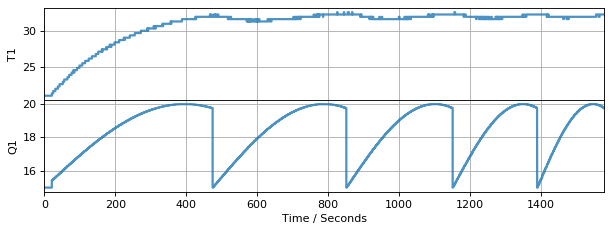

TCLab Model disconnected successfully.


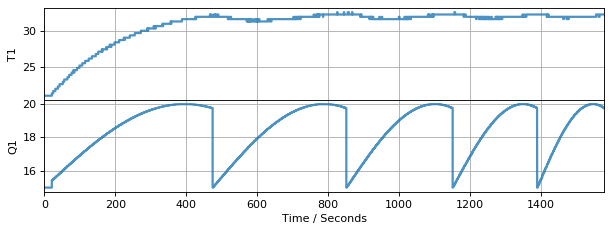

In [23]:
TCLab = tclab.setup(connected=False, speedup=100)
omega_spans = []
run_length_spans = []
with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = tclab.Plotter(h, total_time_min)
    
    t_passed = 0
    
    for omega, run_length in zip(ωs, time_span):
        
        for t in clock(run_length):
            if t < delay:
                Q1 = lab.Q1(15)
            else:
                Q1 = lab.Q1(float(15 + 5*np.sin(omega*t)))

#             h.update(t + index*run_length) 
            print (omega, run_length)
    
            omega_spans.append(omega)
            run_length_spans.append(run_length)
            p.update(t + t_passed)# + index*run_length)
        t_passed +=run_length

In [24]:
h.get_sessions()

[(1, '2020-03-04 19:24:50', 1215)]

In [25]:
h.load_session(1)

In [29]:
data = {"Time" : h.t, "T1" : h.logdict['T1'], "Q1" : h.logdict['Q1'], 'Omegas': omega_spans, 'Run Lengths' :run_length_spans}

In [30]:
for entry in data:
    print (len(data[entry]))

1215
1215
1215
1215
1215


In [31]:
data_frame = pd.DataFrame(data = data)
data_frame.to_csv("Sinusoidals.csv")

In [32]:
data_frame

,Time,T1,Q1,Omegas,Run Lengths
0,0.000000,20.9495,15.000000,0.003981,474.479438
1,21.000000,21.2718,15.417526,0.003981,474.479438
2,22.010000,21.2718,15.437557,0.003981,474.479438
3,23.010000,21.2718,15.457382,0.003981,474.479438
4,25.000000,21.5941,15.496813,0.003981,474.479438
...,...,...,...,...,...
1210,1573.634702,32.2300,19.819782,0.010000,189.495559
1211,1574.634702,32.2300,19.806238,0.010000,189.495559
1212,1576.624702,32.2300,19.777858,0.010000,189.495559
1213,1577.634702,32.2300,19.762729,0.010000,189.495559
